## 7 Evaluation der Cluster

- Darstellung der Cluster mit geeigneten Verfahren

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling  
import missingno as msno
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Zielverzeichnis (bitte anpassen)
TARGET_DIR = r"/Users/danielmini/Projekte/data_analyics26/data_analytics_master/2_data_acquisition/processed_data"

# CSV-Datei finden und laden
csv_files = [f for f in os.listdir(TARGET_DIR) if f.endswith(".csv")]
df = pd.read_csv(os.path.join(TARGET_DIR, csv_files[2]))

print("DataFrame geladen:", df.shape)

DataFrame geladen: (19158, 18)


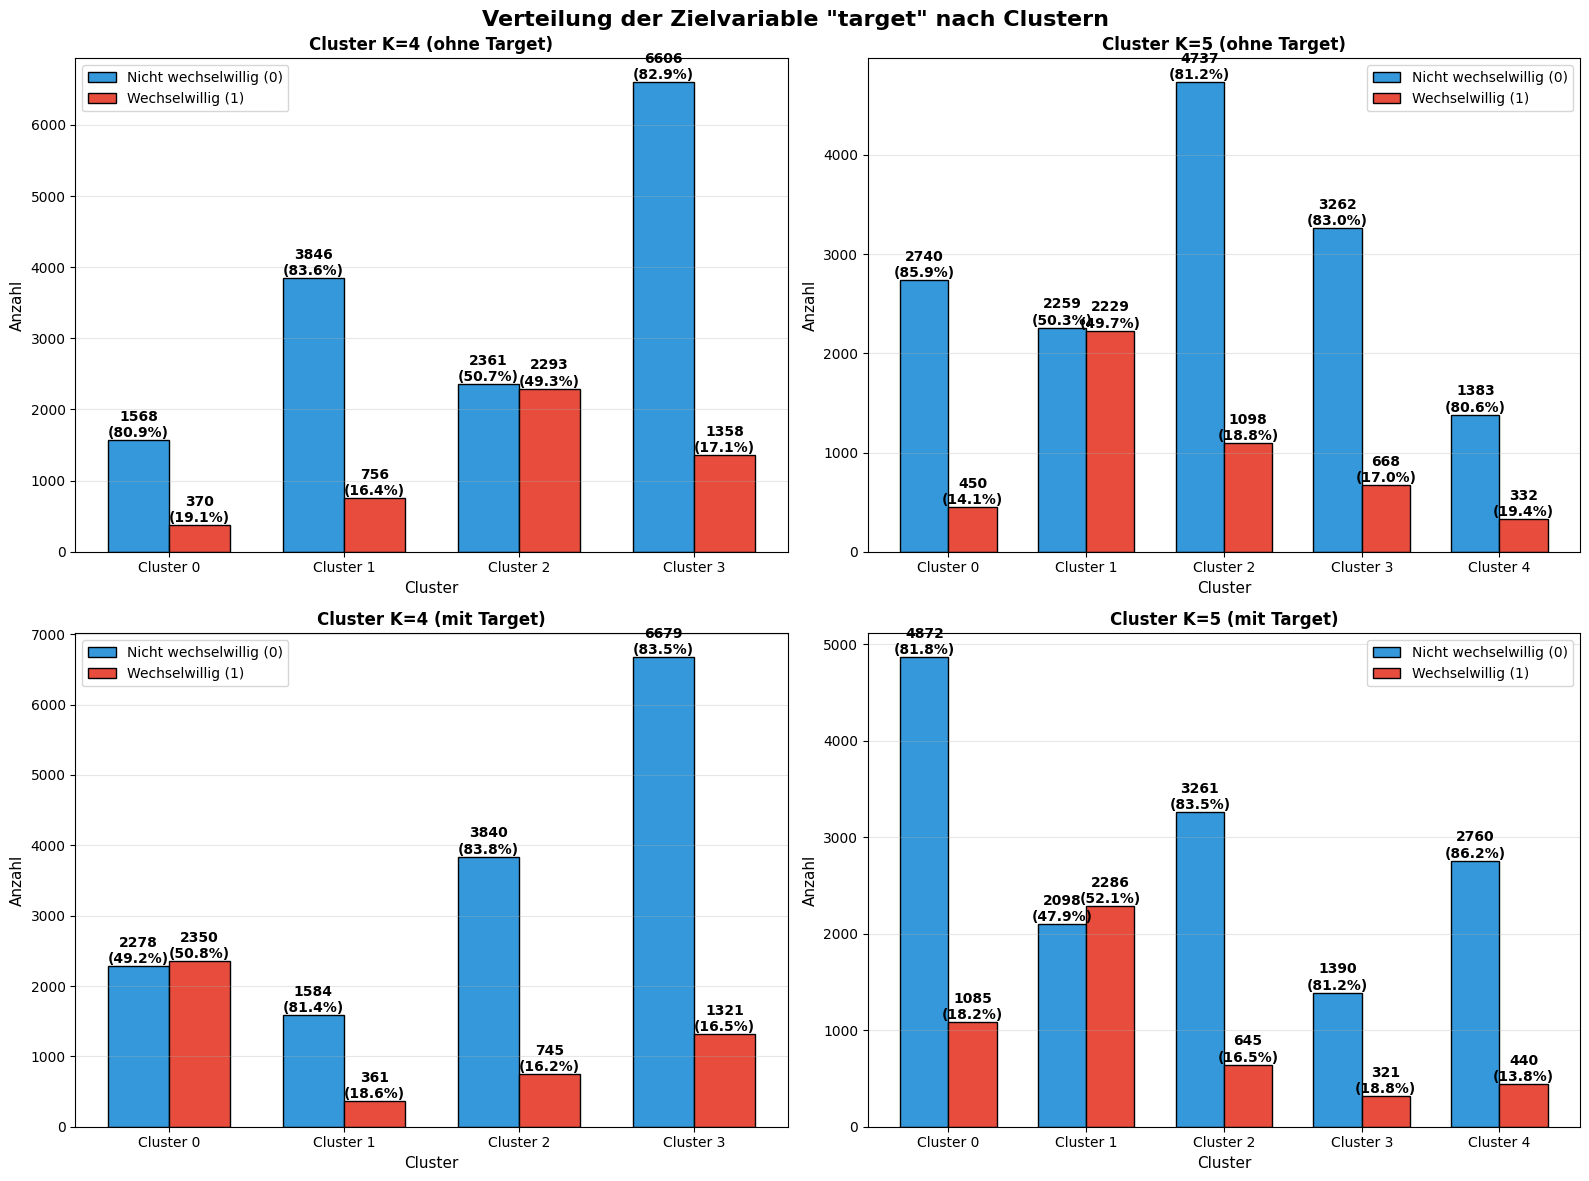

In [5]:
# Verteilung der Zielvariable "target" pro Cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Verteilung der Zielvariable "target" nach Clustern', fontsize=16, fontweight='bold')

cluster_configs = [
    ('cluster_k4_no_target', 'Cluster K=4 (ohne Target)', axes[0, 0]),
    ('cluster_k5_no_target', 'Cluster K=5 (ohne Target)', axes[0, 1]),
    ('cluster_k4', 'Cluster K=4 (mit Target)', axes[1, 0]),
    ('cluster_k5', 'Cluster K=5 (mit Target)', axes[1, 1])
]

for cluster_col, title, ax in cluster_configs:
    # Crosstab für Cluster und Target
    ct = pd.crosstab(df[cluster_col].astype(str), df['target'])
    ct_pct = pd.crosstab(df[cluster_col].astype(str), df['target'], normalize='index') * 100
    
    # Balkendiagramm
    x = np.arange(len(ct.index))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, ct[0.0], width, label='Nicht wechselwillig (0)', 
                   color='#3498db', edgecolor='black')
    bars2 = ax.bar(x + width/2, ct[1.0], width, label='Wechselwillig (1)', 
                   color='#e74c3c', edgecolor='black')
    
    # Prozentwerte über den Balken
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax.text(bar1.get_x() + bar1.get_width()/2., height1,
                f'{int(height1)}\n({ct_pct.iloc[i, 0]:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
        ax.text(bar2.get_x() + bar2.get_width()/2., height2,
                f'{int(height2)}\n({ct_pct.iloc[i, 1]:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Beschriftungen
    ax.set_xlabel('Cluster', fontsize=11)
    ax.set_ylabel('Anzahl', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Cluster {i}' for i in ct.index])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

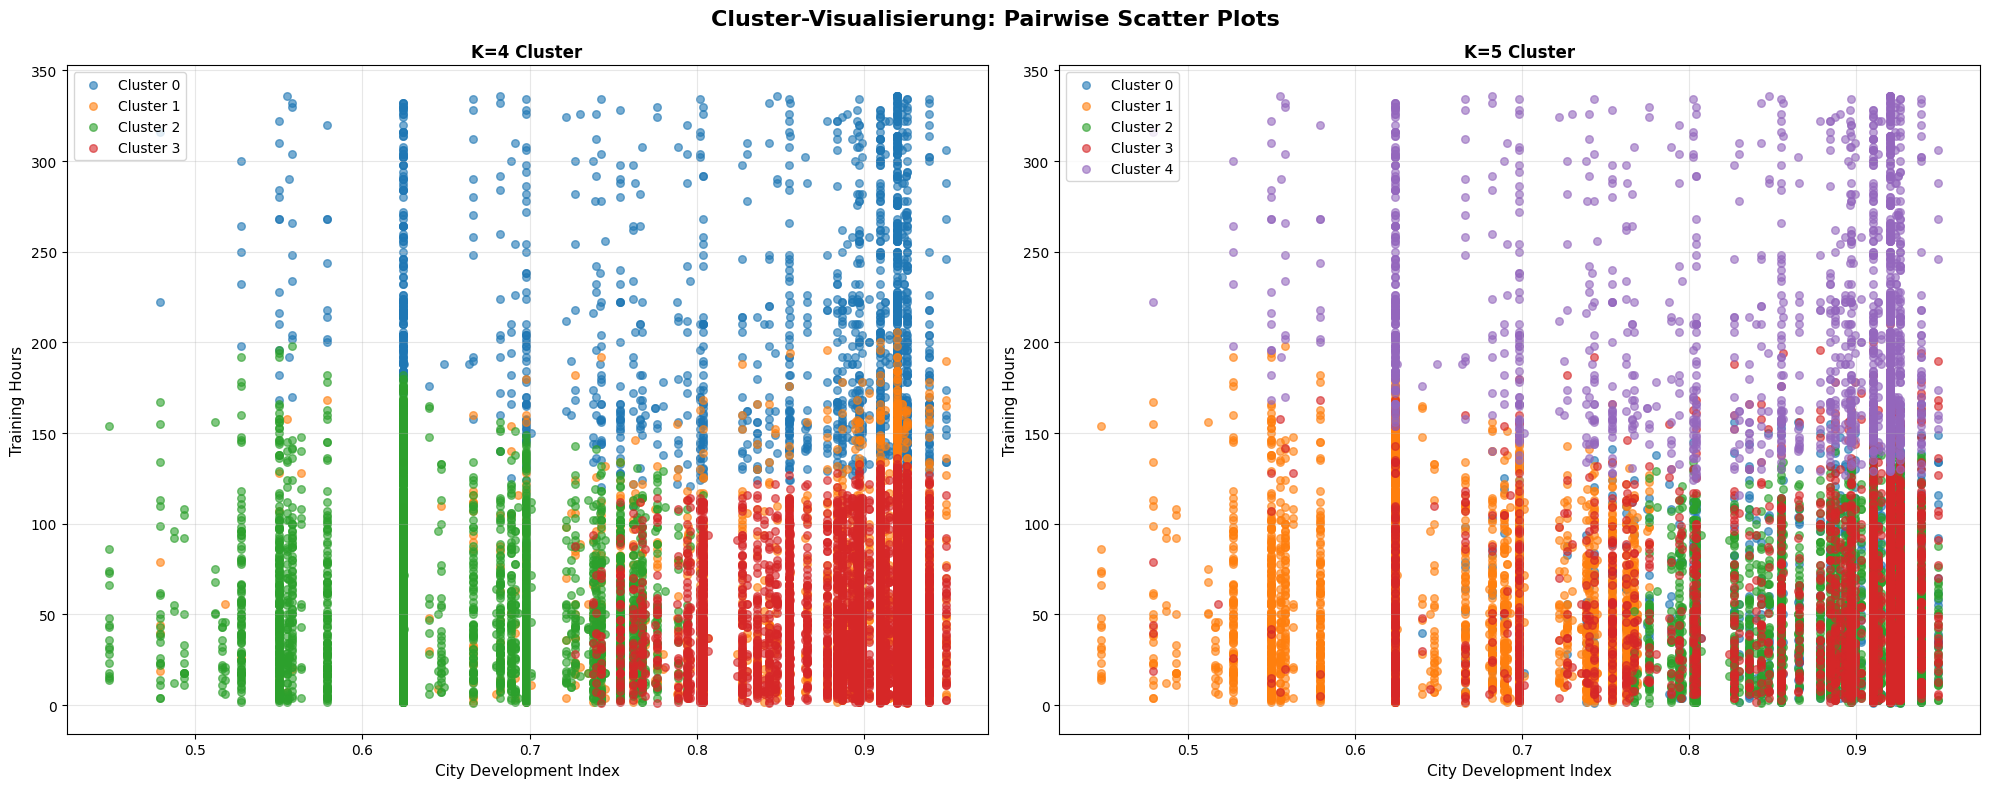

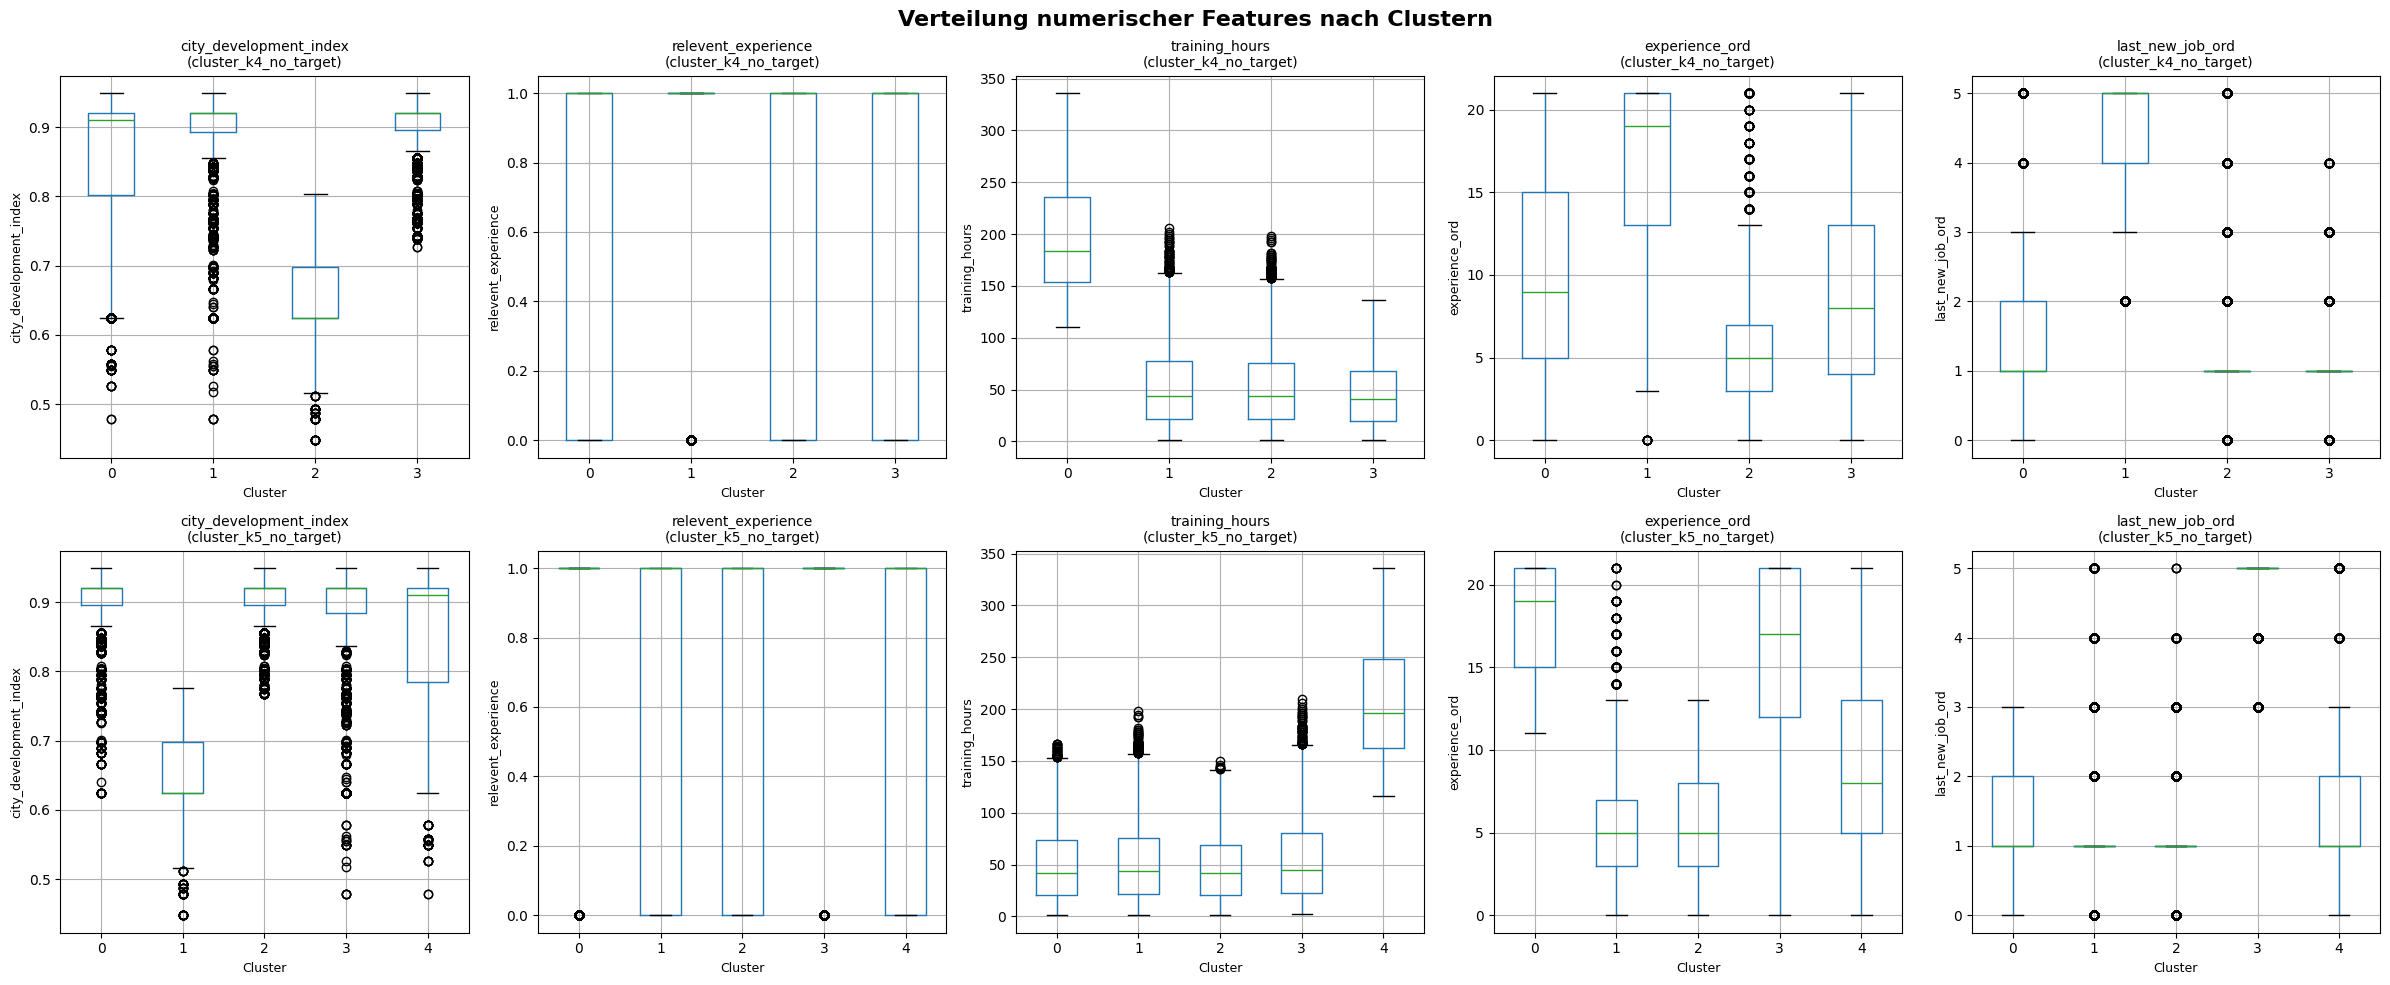

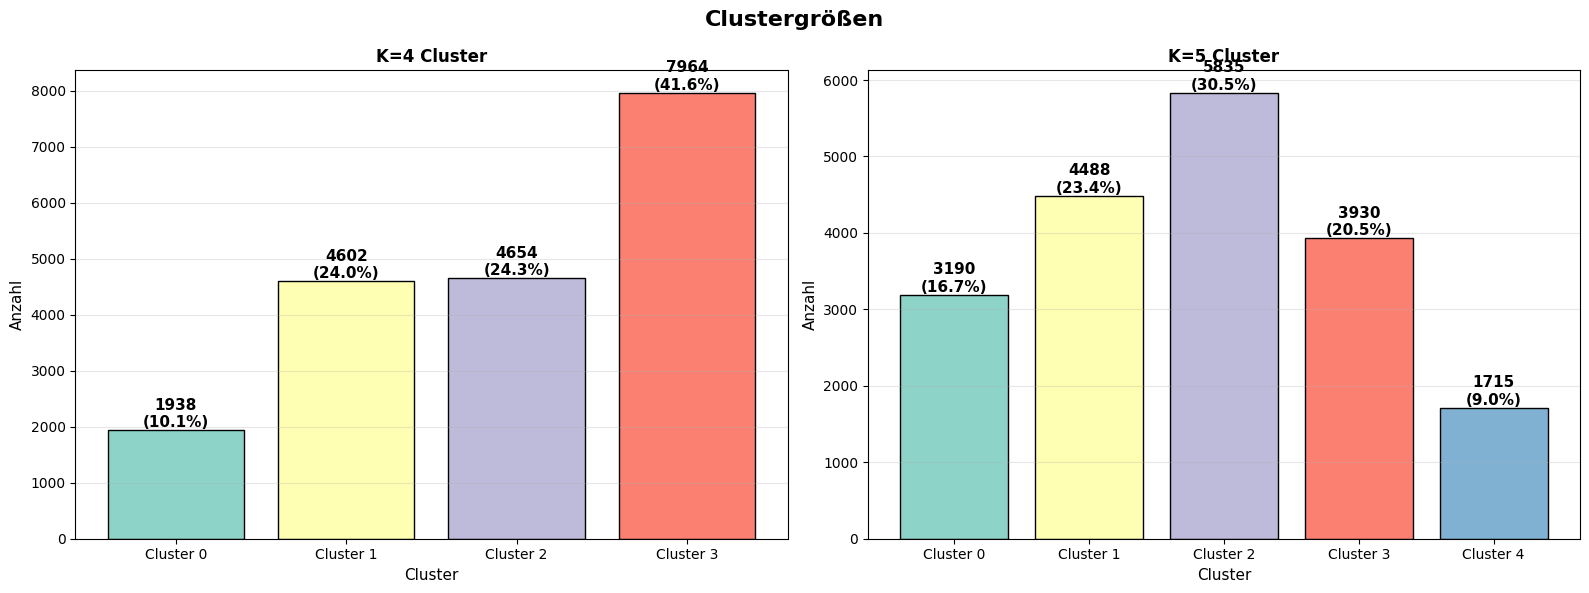

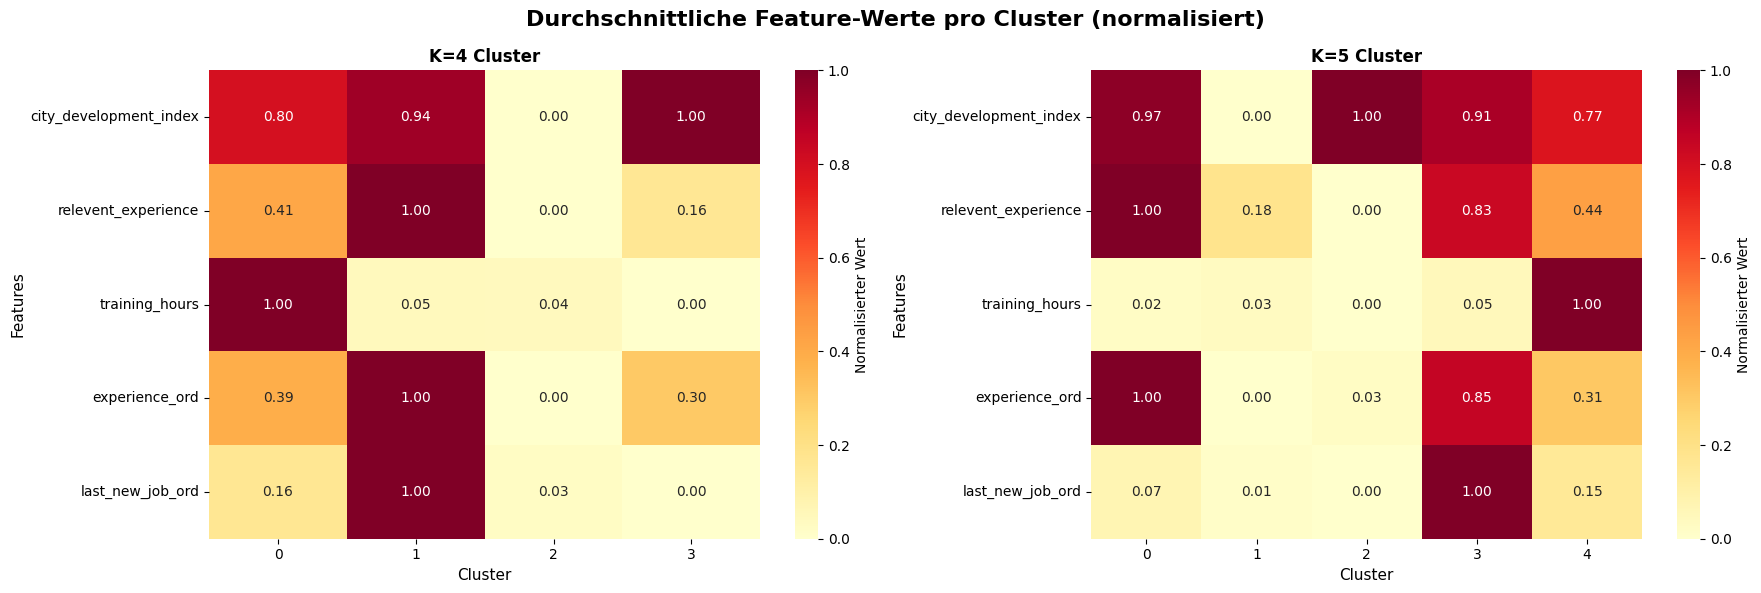

/var/folders/cg/yv60s98n3c386_j153yzvnyw0000gn/T/ipykernel_59894/1037608977.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby(cluster_col).apply(lambda x: x.sample(min(200, len(x)))).reset_index(drop=True)
/var/folders/cg/yv60s98n3c386_j153yzvnyw0000gn/T/ipykernel_59894/1037608977.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby(cluster_col).apply(lambd

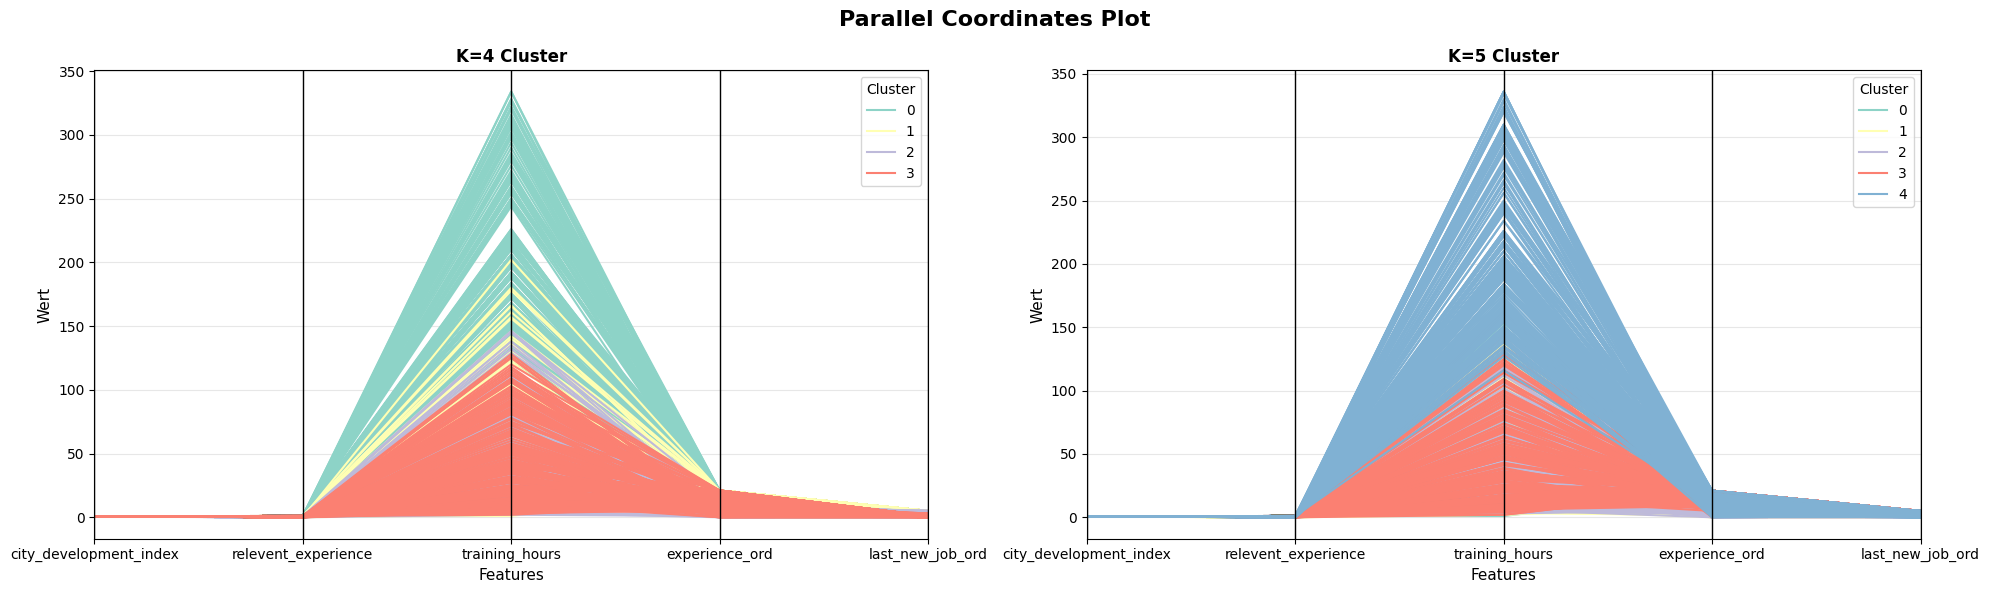

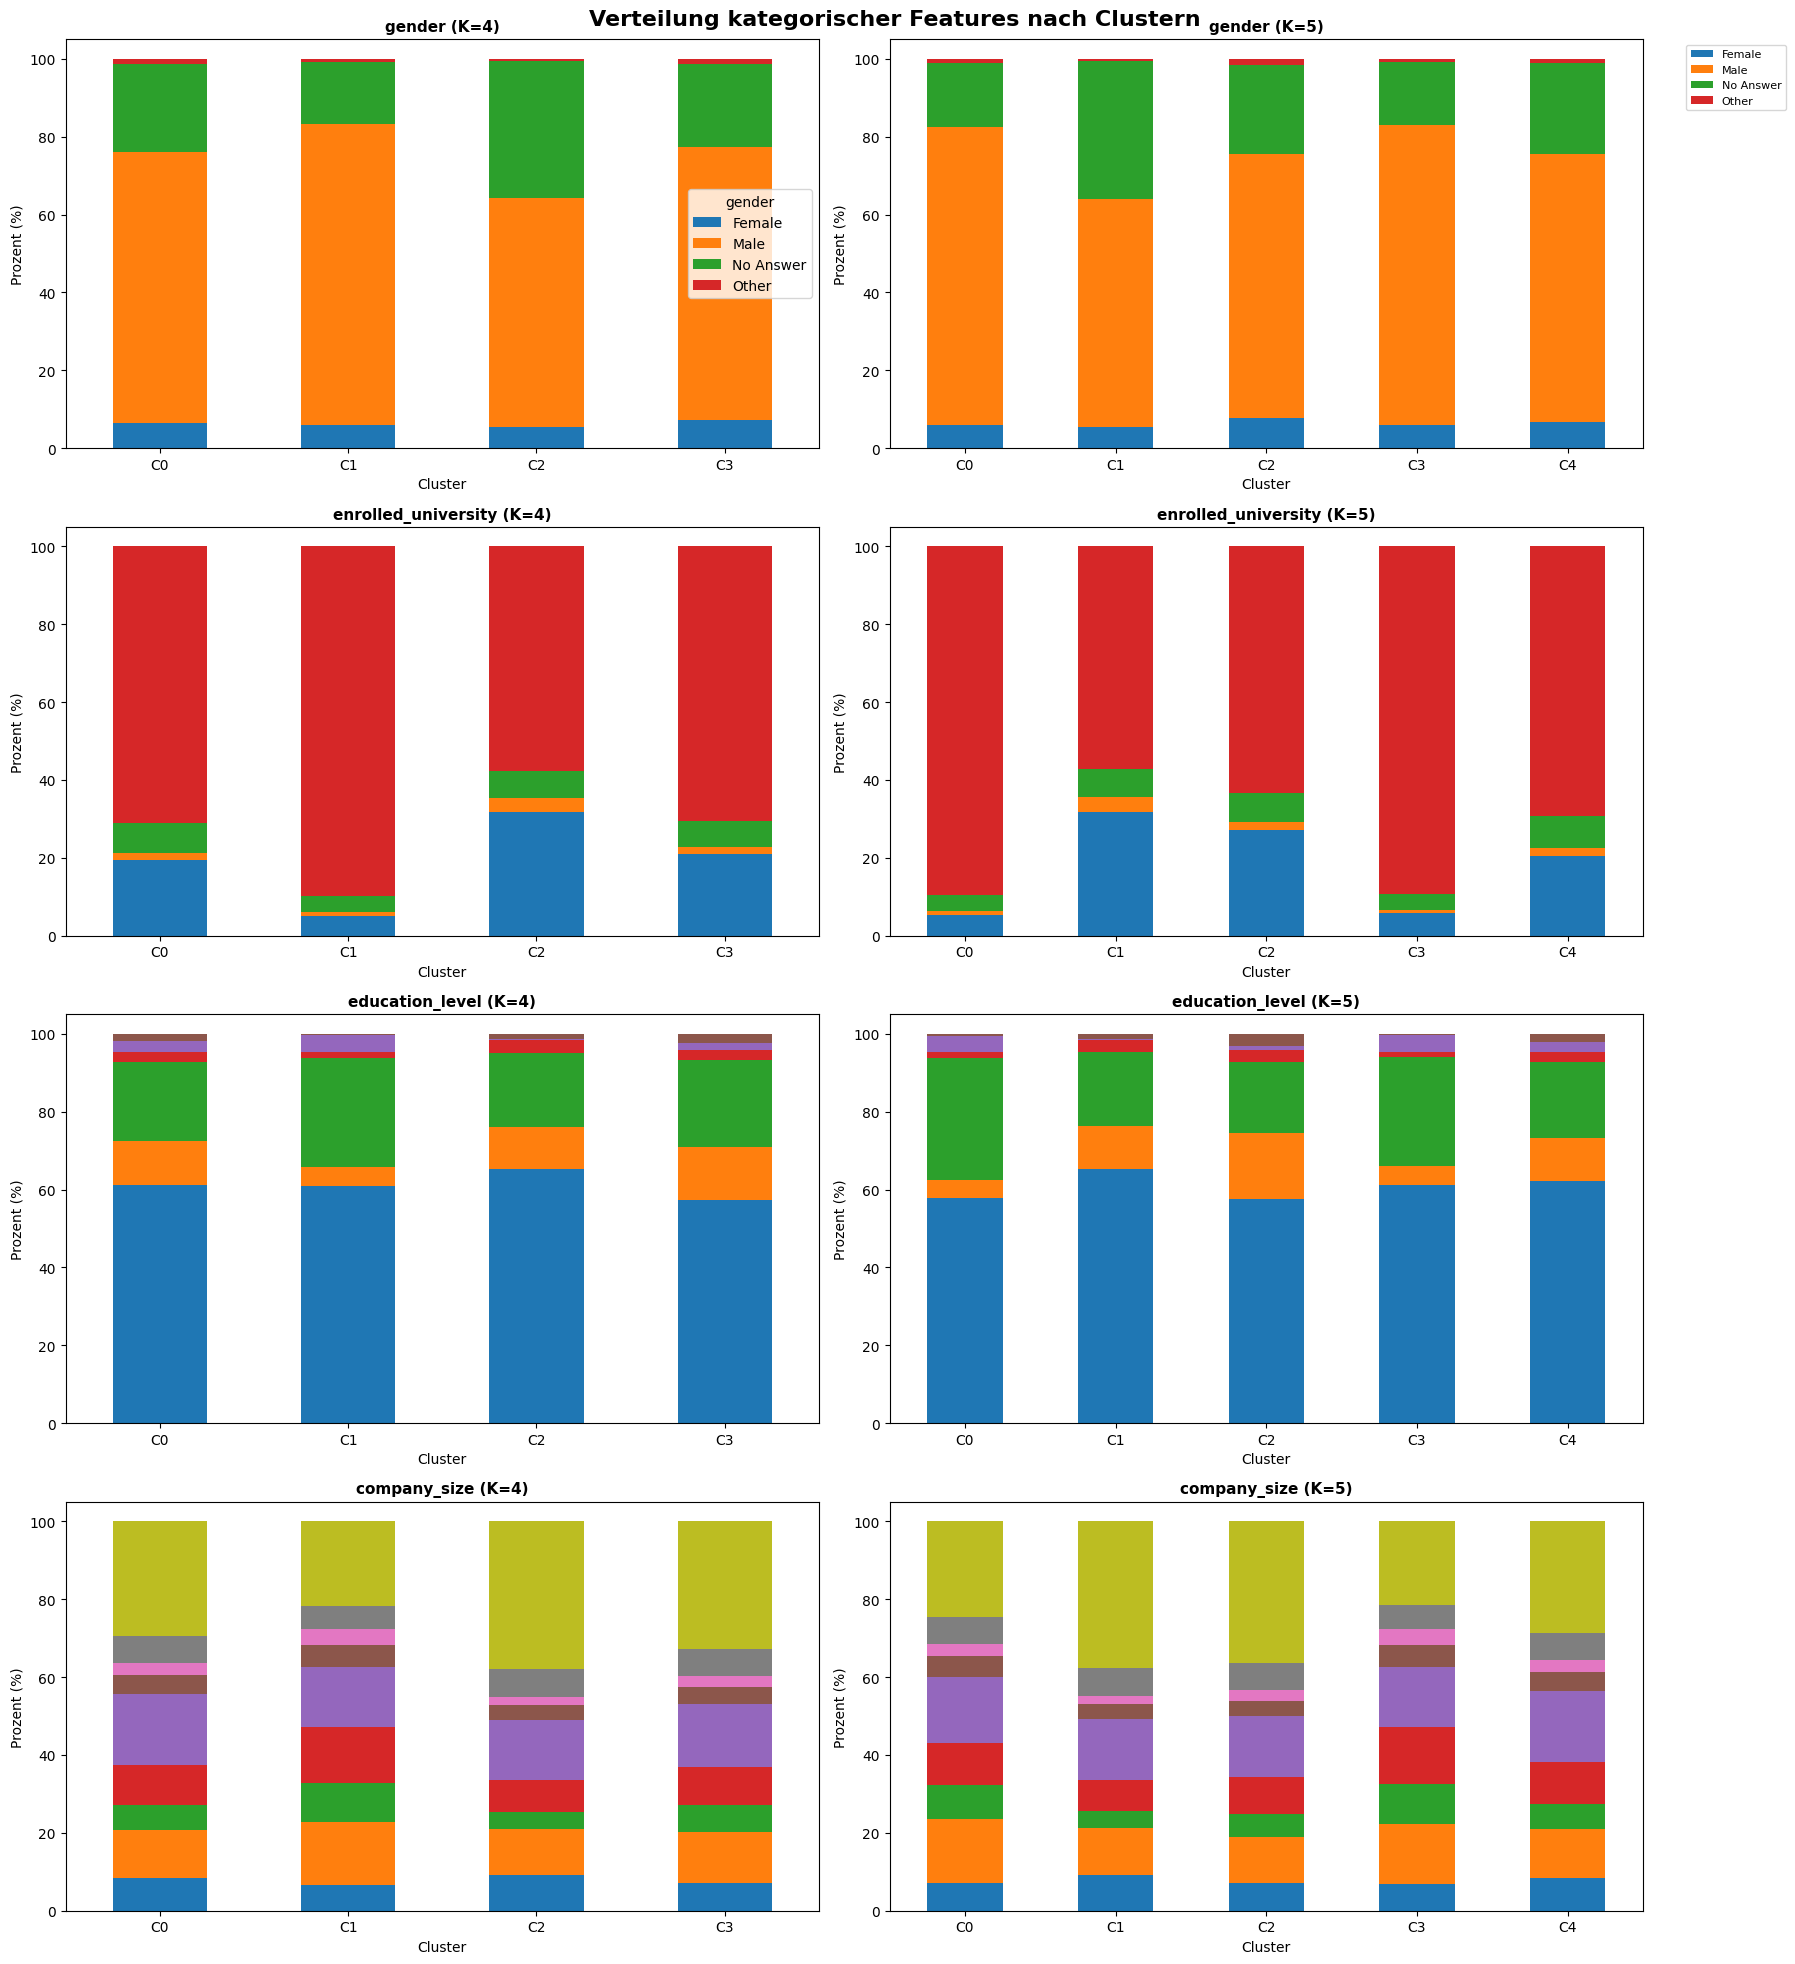

In [7]:
from pandas.plotting import parallel_coordinates

# Auswahl der Features für die Visualisierung (ohne Target)
feature_cols = ['city_development_index', 'relevent_experience', 'training_hours', 
        'experience_ord', 'last_new_job_ord']

# 1. Pairplot für K=4 und K=5 Cluster (ohne Target)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Cluster-Visualisierung: Pairwise Scatter Plots', fontsize=16, fontweight='bold')

for idx, (cluster_col, title) in enumerate([('cluster_k4_no_target', 'K=4 Cluster'),
                        ('cluster_k5_no_target', 'K=5 Cluster')]):
  # Streudiagramm: city_development_index vs training_hours
  for cluster_id in sorted(df[cluster_col].unique()):
    cluster_data = df[df[cluster_col] == cluster_id]
    axes[idx].scatter(cluster_data['city_development_index'], 
             cluster_data['training_hours'],
             label=f'Cluster {cluster_id}',
             alpha=0.6, s=30)
  
  axes[idx].set_xlabel('City Development Index', fontsize=11)
  axes[idx].set_ylabel('Training Hours', fontsize=11)
  axes[idx].set_title(title, fontsize=12, fontweight='bold')
  axes[idx].legend()
  axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Boxplots für numerische Features pro Cluster
fig, axes = plt.subplots(2, 5, figsize=(24, 10))
fig.suptitle('Verteilung numerischer Features nach Clustern', fontsize=16, fontweight='bold')

for idx, cluster_col in enumerate(['cluster_k4_no_target', 'cluster_k5_no_target']):
  for feat_idx, feature in enumerate(feature_cols):
    ax = axes[idx, feat_idx]
    df.boxplot(column=feature, by=cluster_col, ax=ax)
    ax.set_title(f'{feature}\n({cluster_col})', fontsize=10)
    ax.set_xlabel('Cluster', fontsize=9)
    ax.set_ylabel(feature, fontsize=9)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

plt.suptitle('Verteilung numerischer Features nach Clustern', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Clustergrößen
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Clustergrößen', fontsize=16, fontweight='bold')

for idx, (cluster_col, title) in enumerate([('cluster_k4_no_target', 'K=4 Cluster'),
                        ('cluster_k5_no_target', 'K=5 Cluster')]):
  cluster_sizes = df[cluster_col].value_counts().sort_index()
  bars = axes[idx].bar(cluster_sizes.index, cluster_sizes.values, 
             color=plt.cm.Set3(range(len(cluster_sizes))),
             edgecolor='black')
  
  # Prozentangaben über den Balken
  for i, (cluster_id, count) in enumerate(cluster_sizes.items()):
    pct = (count / len(df)) * 100
    axes[idx].text(i, count, f'{count}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
  
  axes[idx].set_xlabel('Cluster', fontsize=11)
  axes[idx].set_ylabel('Anzahl', fontsize=11)
  axes[idx].set_title(title, fontsize=12, fontweight='bold')
  axes[idx].set_xticks(cluster_sizes.index)
  axes[idx].set_xticklabels([f'Cluster {i}' for i in cluster_sizes.index])
  axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Heatmap: Durchschnittswerte der Features pro Cluster
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Durchschnittliche Feature-Werte pro Cluster (normalisiert)', fontsize=16, fontweight='bold')

for idx, (cluster_col, title) in enumerate([('cluster_k4_no_target', 'K=4 Cluster'),
                        ('cluster_k5_no_target', 'K=5 Cluster')]):
  cluster_means = df.groupby(cluster_col)[feature_cols].mean()
  # Normalisierung für bessere Vergleichbarkeit
  cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
  
  sns.heatmap(cluster_means_norm.T, annot=True, fmt='.2f', cmap='YlOrRd', 
        ax=axes[idx], cbar_kws={'label': 'Normalisierter Wert'})
  axes[idx].set_title(title, fontsize=12, fontweight='bold')
  axes[idx].set_xlabel('Cluster', fontsize=11)
  axes[idx].set_ylabel('Features', fontsize=11)

plt.tight_layout()
plt.show()

# 5. Parallel Coordinates Plot

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Parallel Coordinates Plot', fontsize=16, fontweight='bold')

for idx, (cluster_col, title) in enumerate([('cluster_k4_no_target', 'K=4 Cluster'),
                        ('cluster_k5_no_target', 'K=5 Cluster')]):
  # Sample für bessere Übersichtlichkeit
  sample_df = df.groupby(cluster_col).apply(lambda x: x.sample(min(200, len(x)))).reset_index(drop=True)
  plot_data = sample_df[feature_cols + [cluster_col]].copy()
  plot_data[cluster_col] = plot_data[cluster_col].astype(str)
  
  parallel_coordinates(plot_data, cluster_col, ax=axes[idx], 
            color=plt.cm.Set3(range(len(df[cluster_col].unique()))))
  axes[idx].set_title(title, fontsize=12, fontweight='bold')
  axes[idx].set_xlabel('Features', fontsize=11)
  axes[idx].set_ylabel('Wert', fontsize=11)
  axes[idx].legend(title='Cluster', loc='best')
  axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Kategorische Features: Verteilung pro Cluster
categorical_features = ['gender', 'enrolled_university', 'education_level', 'company_size']

fig, axes = plt.subplots(4, 2, figsize=(18, 20))
fig.suptitle('Verteilung kategorischer Features nach Clustern', fontsize=16, fontweight='bold')

for feat_idx, feature in enumerate(categorical_features):
  for cluster_idx, (cluster_col, title) in enumerate([('cluster_k4_no_target', 'K=4'),
                              ('cluster_k5_no_target', 'K=5')]):
    ax = axes[feat_idx, cluster_idx]
    
    # Crosstab normalisiert
    ct = pd.crosstab(df[cluster_col], df[feature], normalize='index') * 100
    ct.plot(kind='bar', stacked=True, ax=ax, legend=feat_idx==0)
    
    ax.set_title(f'{feature} ({title})', fontsize=11, fontweight='bold')
    ax.set_xlabel('Cluster', fontsize=10)
    ax.set_ylabel('Prozent (%)', fontsize=10)
    ax.set_xticklabels([f'C{i}' for i in ct.index], rotation=0)
    
    if feat_idx == 0 and cluster_idx == 1:
      ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    elif feat_idx > 0:
      ax.legend().set_visible(False)

plt.tight_layout()
plt.show()